<a href="https://colab.research.google.com/github/SmirnygaTotoshka/FBB_Courses/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22ML_in_Bio_Lec_4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение в биологии

### Лекция 4: Методы понижения размерности

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

## Обучение без учителя (unsupervised learning)

На прошлых занятиях мы разобрали, что такое **обучение с учителем** и какие **модели** применяются для решения подобных задач.

Однако обучение с учителем **не единственный класс задач**, которые можно решить с помощью машинного обучения. Зачастую возникает необходимость **определить паттерны в неразмеченных данных**.

Такие задачи включают в себя:
* кластеризацию,
* снижение размерности,
* поиск правил (ассоциаций),
* генерация данных и др.

Сегодня мы рассмотрим задачу **снижения размерности**: разберемся, зачем это нужно, как применяется в биологии и какие подводные камни здесь могут быть.

## Задача снижения размерности

### Проклятие размерности

**При увеличении размерности** данных (т.е. добавлении новых признаков) **объем** пространства **увеличивается очень быстро** (экспоненциально).

Из-за такого быстрого роста данные становятся редкими (sparse), в частности, уменьшается отношение расстояний до ближайшей точки и до наиболее далекой. Таким образом, получается, что при увеличении размерности **объекты становятся все более равноудаленными друг от друга**.

Вот как это выглядит на сгенерированных данных:

![knn_avg_dist_synt.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/knn_avg_dist_synt.png)

Однако **на реальных данных** все выглядит по-другому:

![knn_avg_dist_real_vs_synt.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/knn_avg_dist_real_vs_synt.png)

**Почему так происходит?**

Дело в том, что настоящие данные на самом деле располагаются в пространстве меньшей размерности, чем количество признаков.

Причина этого достаточно проста: **признаки не являются полностью независимыми**. В результате, если нашими признаками являются, к примеру, рост и вес, то мы почти не будем наблюдать как людей с высоким ростом и очень низким весом, так и людей с низким ростом и очень высоким весом.

Таким образом, настоящие точки на самом деле обычно **находятся в пространстве меньшго размера**, чем точки с независимыми признаками.

А можно ли считать, что эти точки **расположены в пространстве меньшей размерности**?

Это предположение справедливо во многих случаях. Представим, например, **пространство изображений** размером 300x300 пикселей и отображение на нем изображений лица определенного человека:

![manifold2.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/manifold2.png)

Источник: [Towards Data Science](https://towardsdatascience.com/42cfd61f5183)

Очевидно, что **не любая картинка 300x300 является изображением лица человека**. Подавляющее большинство таких картинок содержат шум, и только очень, очень небольшое множество - лица.

Достаточно очевидно, что для описания картинки с лицом (если мы знаем, что оно на ней есть, а остальное содержимое нам не очень важно) **90'000 измерений избыточны**.

Получается, во многих случаях уместно предположение о том, что наши данные расположены в пространстве меньшей размерности, чем $\mathbb{R}^N$, т.е. подобным образом:

![manifold1.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/manifold1.png)

Такое предположение в литературе называется **Manifold assumption** (предположение о многообразии).

Таким образом можно попытаться **снизить размерность** наших данных - т.е. представить каждый из элементов (точек) нашей выборки в координатах внутри многообразия.

Но **зачем это вообще нужно**?

Снижение размерности помогает делать следующие вещи:
* **Визуализировать многомерные данные** на двумерных и трехмерных графиках
* Искать **внутренние закономерности** в данных
* **Сжимать** данные
* Бороться с **переобучением** (многие модели склонны к этому при большом количестве признаков)
* Создавать новые признаки
* И т.д.

## Методы снижения размерности

Сегодня мы рассмотрим **наиболее популярные в биологии** методы снижения размерности:
* PCA и kernel-PCA
* t-SNE
* UMAP

## PCA (principal component analysis)

**PCA - анализ главных компонент** - был предложен еще в 1901 году Карлом Пирсоном.

Метод заключается в следующем: необходимо в пространстве данной размерности найти **линейное подпространство меньшей размерности**.

При этом подойдет не любое подпространство. Нужно, чтобы **точки, спроецированные на это подпространство** (гиперплоскость), **сохраняли максимальный объем информации**.

Как это работает? **Упростим задачу**, чтобы понять основной принцип.

Представим, что наши данные имеют два измерения (точки на плоскости). Задачей будет **получить для каждой точки только одно число, которое будет ее описывать наилучшим образом**.

Такое число можно представить в виде **координаты проекции точки на прямую**. При этом прямая выбирается так, чтобы **спроецированные на нее точки имели наибольшую дисперсию**.

Посмотрим, как это выглядит графически:

![pca.gif](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/pca.gif)

Существует множество способов формализовать задачу PCA:
* через максимизацию дисперсии
* через аппроксимацию данных линейными многообразиями меньшей размерности
* через приближение исходной матрицы вырожденной матрицей с рангом k
* Через простроение для данной многомерной случайной величины **ортогонального** преобразования координат, в результате которого корреляции между отдельными координатами станут нулевыми

Одно из главных предположений -- хорошее качество восстановления данных в исходное пространство (то есть хотим потерять наименьшее количество информации).

Пусть у нас исходные признаки $X_{i,j}$  размера $D$. Хотим перейти в пространство новых признаков $Z_{i,j}$ размера $d$, при этом  $d \le D$.

$z_{i,j} = \sum_{k=1}^{D}{w_{j,k}x_{i,k}} = \sum_{k=1}^{D}{x_{i,k}w_{k,j}^T}$,

где z - новые признаки, x - старые признаки, а w - вклад каждого x в z.

Матричная запись: $Z = XW^T$

Одно из условий - ортогональность новых признаков, то есть $W^{T}W = I$

Тогда получаем, что при $d = D$ 

$\tilde{X} = ZW$,

а при снижении размерности задача выглядит как минимизация разницы между восстановленным иксом и исходным.

$||X - ZW||^2 \rightarrow min_{w}$

### Попробуем визуализировать наши данные с помощью PCA

In [ ]:
import sklearn.datasets
from sklearn.decomposition import PCA

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

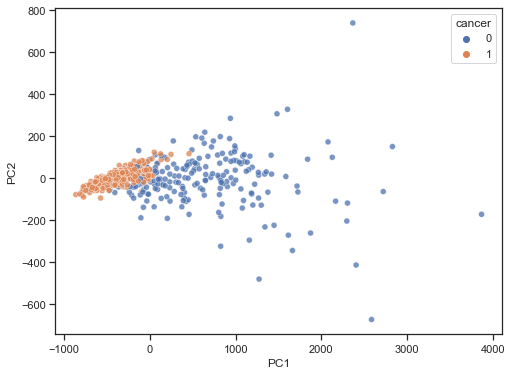

In [ ]:
df = pd.DataFrame({"PC1": X_pca[:,0],
                   "PC2": X_pca[:,1],
                   "cancer": y})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75)

**Для визуализации** данных обычно берут **2-3 компоненты**. А сколько компонент надо брать для других задач?

### Значимость главных компонент

Таким образом мы находим **линейное подпространство**, в котором предположительно находится **описываемое данными многообразие** (manifold). Как нам понять, какую размерность оно имеет?

Чтобы это понять, нужно иметь определенную меру того, **насколько полезна каждая из добавляемых компонент**. Для этого существует понятие **объясненной дисперсии** (explained variance).

Очевидно, что **с помощью N компонент** (где N - число признаков) **можно описать весь массив данных** (т.е. 100% дисперсии).

**Как подобрать оптимальное число компонент?**

Один из способов: **задать определенную долю дисперсии**, которая должна быть объяснена компонентами.

In [ ]:
n = np.min(X.shape)

In [ ]:
pca = PCA(n_components=n)
X_pca = pca.fit_transform(X)

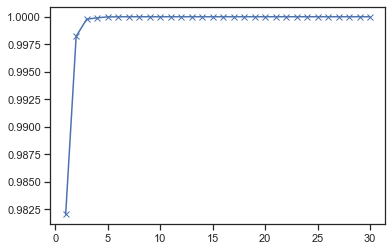

In [ ]:
total_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1, n + 1), total_explained, "x-")
plt.show()

Оказывается, первые две компоненты в этом датасете объясняют более 99,7% дисперсии. Обычно это означает, что данные или **устроены очень просто**, или **не нормализованы**.

Попробуем нормализовать данные:

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
pca = PCA(n_components=n)
X_pca = pca.fit_transform(X_scaled)

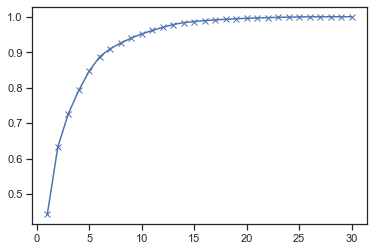

In [ ]:
total_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1, n + 1), total_explained, "x-")
plt.show()

Теперь график выглядит более правдоподобно.

Попробуем выбрать **набор главных компонент, суммарно объясняющих 95% дисперсии**.

In [ ]:
threshold = 0.95
top_n = np.argmax(total_explained >= threshold) + 1  # Finds first True
print(top_n)

10


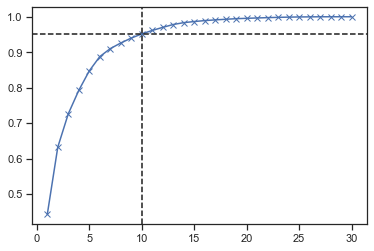

In [ ]:
total_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1, n + 1), total_explained, "x-")
plt.axvline(x=top_n, color="k", ls="--")
plt.axhline(y=threshold, color="k", ls="--")
plt.show()

Получаем, что 10 компонент объясняют 95% дисперсии.

Существует также **еще более простой визуальный способ** определения количества главнх компонент - т.н. **"метод локтя"**.

В нем для каждой компоненты считаем **долю дисперсии, которую мы не объясним** $(1 - EV_N)$, если возьмем первые $N$ компонент.

Ищем такое наибольшее $N$, что $1 - EV_N >> 1 - EV_{N-1}$.

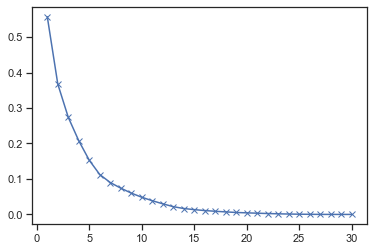

In [ ]:
total_explained = 1 - np.cumsum(pca.explained_variance_ratio_[:n])
plt.plot(np.arange(1, n + 1), total_explained, "x-")
plt.show()

По графику видим, что искомое количество компонент лежит в диапазоне 5 - 7.

Также можно оценить значимость каждой компоненты статистически: **Permutation**.
* Перемешиваем значения каждого признака и получаем матрицу признаков, которая не содержит никакой информации (маргинальные распределения значений признаков).
* Деляем PCA. Любая Explained Variance просто из-за природы данных.
* Повторяем 100-1000 раз.
* Пусть на реальных данных k-я компонента объясняет n% дисперсии. 
* Смотрим на *распределение* доли дисперсии, объясняемой k-й компонентой для нашей выборки случайных данных.
* Можем сравнить и принять решение, ловит ли k-я компонента что-то реальное или просто случайный шум.

### PCA в науке

Анализ главных компонент активно используют в научных трудах.

Чаще всего PCA используется для **визуализации данных**:

![pca_example_1.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/pca_example_1.png)

"Голый" анализ главных компонент **редко используется сам по себе**, существуют много **основанных на PCA методов** и видов **анализа после PCA**.

![pca_example_2.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/pca_example_2.png)

### Плюсы и минусы PCA

**PCA - очень простой линейный способ снижения размерности** ваших данных.

**Плюсы**:
* Быстрые расчеты
* Надежность метода
* Простая интерпретация (линейный метод)

**Минусы**:
* Плохо улавливает нелинейные зависимости в данных
* Возможна потеря "интересных" данных

**Как можно потерять важные данные при PCA?** Давайте сгенерируем пример:

In [ ]:
per_group = 500
arrays, labels = [], []
for group_id in range(5):
    x = np.random.normal(0, 10, per_group) + group_id
    y = np.random.normal(0, 10, per_group) + group_id
    z = np.random.normal(0, 0.1, per_group) + group_id
    group = np.array([x, y, z]).T
    arrays.append(group)
    
    group_labels = np.full(per_group, group_id)
    labels.append(group_labels)

In [ ]:
data = pd.DataFrame(np.concatenate(arrays), columns=["X", "Y", "Z"])
data["label"] = pd.Series(np.concatenate(labels))
data.sample(3)

,X,Y,Z,label
2308,16.475801,-8.535863,3.805266,4
249,-4.032094,11.400553,0.161914,0
2177,-2.234731,-7.065422,4.133908,4


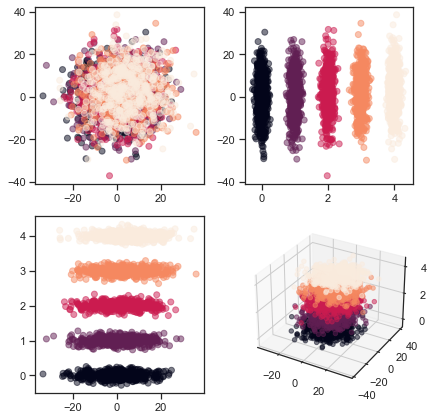

In [ ]:
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(6, 6))

for i, (c1, c2) in enumerate([("X", "Y"), ("Z", "Y"), ("X", "Z")], 1):
    ax = fig.add_subplot(2, 2, i)
    ax.scatter(data[c1], data[c2], c=data["label"], alpha=0.5)
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter(data["X"], data["Y"], data["Z"], c=data["label"], alpha=0.5)
plt.tight_layout(); plt.show()

Посмотрим, что получилось на PCA:

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data[["X", "Y", "Z"]])

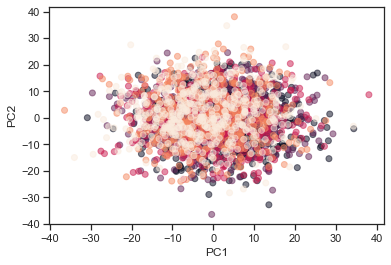

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=data["label"], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Разбиение на группы полностью исчезло!

Немного помогает исправить ситуацию **нормализация признаков**.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[["X", "Y", "Z"]])

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

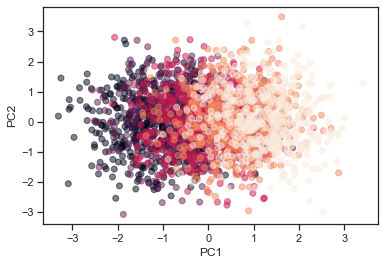

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=data["label"], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Kernel-PCA

Иногда нужно **спроецировать данные на нелинейное подпространство**, которое соответствует манифолду для ваших данных.

В таком случае удобно применить **Kernel trick**, который рассматривался на предыдущей лекции.

![sphx_glr_plot_kernel_pca_001.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/sphx_glr_plot_kernel_pca_001.png)

*Источник: [Scikit-learn Examples](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html)*

### Попробуем визуализировать данные с помощью Kernel-PCA

In [ ]:
import sklearn.datasets
from sklearn.decomposition import KernelPCA

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
k_pca = KernelPCA(n_components=2, kernel="sigmoid")
X_pca = k_pca.fit_transform(X_scaled)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

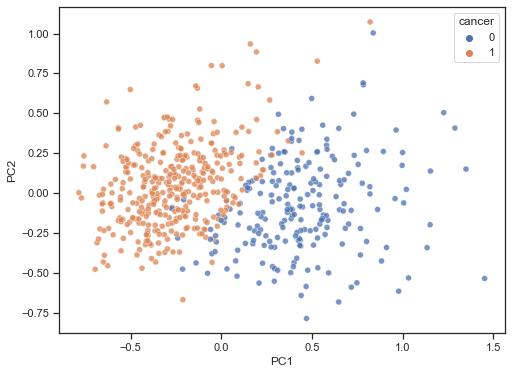

In [ ]:
df = pd.DataFrame({"PC1": X_pca[:,0],
                   "PC2": X_pca[:,1],
                   "cancer": y})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75)

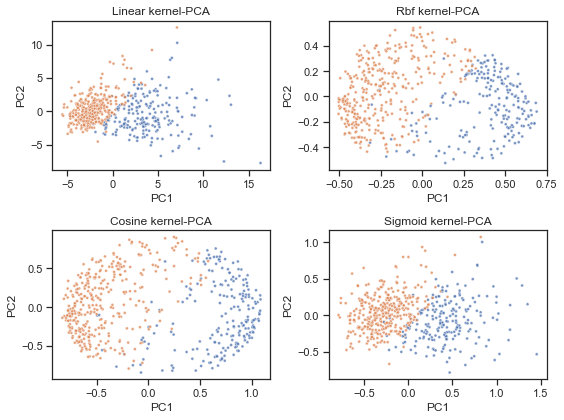

In [ ]:
plt.figure(figsize=(8, 6))
for i, kernel in enumerate(["linear", "rbf", "cosine", "sigmoid"], 1):
    k_pca = KernelPCA(n_components=2, kernel=kernel)
    X_pca = k_pca.fit_transform(X_scaled)
    df_s = pd.DataFrame({"PC1": X_pca[:,0], "PC2": X_pca[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"{kernel.capitalize()} kernel-PCA")
plt.tight_layout()

### Плюсы и минусы Kernel-PCA

**PCA - очень простой линейный способ снижения размерности** ваших данных.

**Плюсы**:
* Быстрый расчет (благодаря kernel trick)
* Поддерживаются нелинейные зависимости (семейство, поддерживаемое ядром)

**Минусы**:
* Интерпретация становится труднее
* Необходимо понимание типов ядра и их гиперпараметров для обучения
* Нет поддержки произвольных нелинейных функций

## t-SNE и UMAP

Методы PCA и Kernel-PCA ищут **проекцию наших точек на какое-то подпространство** (линейное или заданное ядром нелинейное). При этом одним из условий было то, что мы можем восстановить данные, вернувшить в исходное пространство, с хорошей точностью.

Весьма значительный минус PCA-подобных методов заключается в том, что **они обеспечивают сохранение глобальной дисперсии** по всем точкам, **но не дисперсии в локальных окрестностях** каждой из точек.

Попробуем решить немного другую задачу: забудем про восстановление данных, хотим получить отображение в новое пространство меньшей размерности сохраняя информацию о расстояниях между объектами. При этом расстояния для далеких друг от друга объектов нас интересуют слабо, главное сохранить расстояния между **близкими** объектами. 

### t-SNE

В этом методе мы пытаемся найти такое подпространство, в котором **учитываются в наибольшей степени расстояния между близкими объектами**.

**t-SNE** означает **t-distributed Stochastic Neighbour Embedding**.

* **t**-distributed -> используется распределение Стьюдента
* **S**tochastic -> использует вероятностные подходы
* **N**eighbor -> сохраняет дисперсию близких друг к другу точек
* **E**mbedding -> снижает размерность данных

Упрощенно говоря, t-SNE - это алгоритм, который генерирует **слегка отличающиеся** результаты при каждом запуске на тех же данных и преимущественно обеспечивает **сохранение локальной структуры точек**.

### Принцип работы t-SNE

t-SNE строит такое **распределение вероятностей встретить пару объектов**, что близкие друг к другу пары объектов имеют высокую вероятность, а далекие друг от друга - низкую.

После этого t-SNE **итеративно размещает точки** на пространстве меньшей размерности так, чтобы они давали как можно более похожее распределение.

**Чем дальше друг от друга находится пара точек, тем меньший вклад она будет вносить в новую структуру.**

### Попробуем визуализировать наши данные с помощью t-SNE

In [ ]:
import sklearn.datasets
from sklearn.manifold import TSNE

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

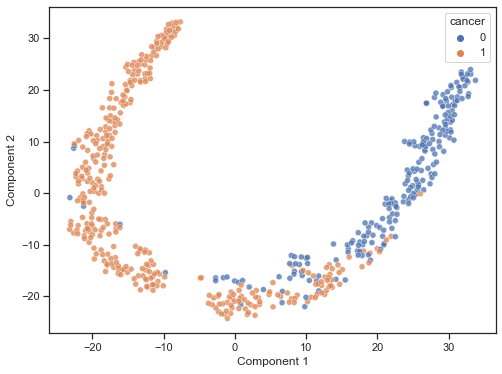

In [ ]:
df = pd.DataFrame({"Component 1": X_tsne[:,0],
                   "Component 2": X_tsne[:,1],
                   "cancer": y})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df, alpha=0.75)
plt.show()

Ура, мы обучили модель t-SNE "из коробки"!

### Гиперпараметры t-SNE

У алгоритма t-SNE есть **два ключевых гиперпараметра**, которые могут очень сильно влиять на результат:

* `n_iter` - количество итераций, которые производит алгоритм
* `perplexity` - нетривиальная вещь; упрощенно можно сказать, что это количество точек в окрестности, которые учитываются алгоритмом t-SNE

Попробуем посмотреть, как эти параметры влияют на визуализацию данных!

Perplexity **рекомендуют выбирать в диапазоне 5 - 50**. Она не обязательно должна быть целой.

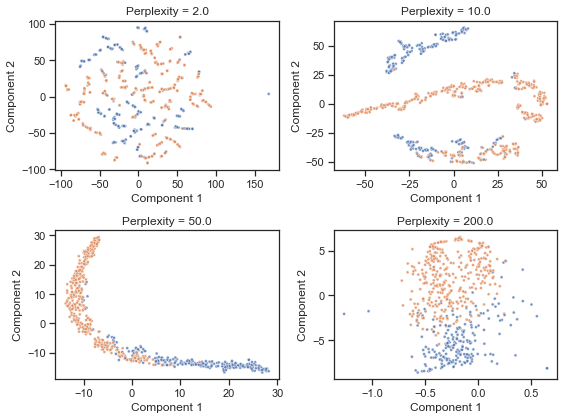

In [ ]:
plt.figure(figsize=(8, 6))
for i, perp in enumerate([2.0, 10.0, 50.0, 200.0], 1):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
    X_tsne = tsne.fit_transform(X)
    df_s = pd.DataFrame({"Component 1": X_tsne[:,0], "Component 2": X_tsne[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"Perplexity = {perp}")
plt.tight_layout()

Количество итераций обычно **чем больше, тем лучше, но дольше**.

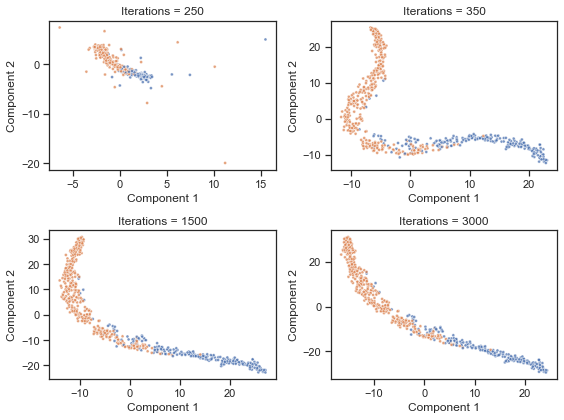

In [ ]:
plt.figure(figsize=(8, 6))
for i, n_iter in enumerate([250, 350, 1500, 3000], 1):
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=n_iter)
    X_tsne = tsne.fit_transform(X)
    df_s = pd.DataFrame({"Component 1": X_tsne[:,0], "Component 2": X_tsne[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"Iterations = {n_iter}")
plt.tight_layout()

**Краткие выводы**:

* Чем больше мы совершаем итераций (`n_iters`), тем лучше.
  * Следует соблюдать баланс между тем, что при увеличении `n_iters` растет не только качество, но и время работы алгоритма.
* `perplexity` - очень хитрый параметр.
  * `perplexity` очень сильно влияет на то, какую форму будет иметь манифолд при отображении.
  * Слишком низкие и слишком высокие значения `perplexity` могут давать артефакты: "кластеры видны, когда их нет" и "кластеры не видны, когда они есть".

Следует **очень аккуратно интерпретировать результаты t-SNE**, особенно выделенные алгоритом кластеры.

Более подробно посмотреть, **как разные параметры влияют на результат работы t-SNE**, можно [здесь](https://distill.pub/2016/misread-tsne/).

### Плюсы и минусы t-SNE

**Плюсы**:
* Способен выделять произвольные нелинейные зависимости
* Учитывается локальная топология точек
* Стохастический алгоритм -> возможно оценить стабильность "кластеров"

**Минусы**:
* Медленное обучение на больших объемах данных
* Получаемое пространство почти не интерпретируемо
* Используется почти исключительно для визуализации,
тк выделять больше 2-3 компонент неимоверно долго
* Множественные артефакты и искажения топологии
  * Для снижения их количества важно понимание гиперпараетров
* Слабо учитывается глобальная топология точек
* Стохастический алгоритм -> очень сильно одвержен шуму

### UMAP

![umap_mammoth.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/umap_mammoth.png)

### Принцип работы UMAP

По своей сути **UMAP очень сильно похож на t-SNE**. Алгоритм так же обеспечивает **сохранение локальной структуры данных в ущерб глобальной**.

UMAP строит **параметризуемое графовое представление** данных в исходном пространстве.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/dtrees/umap_neighbors.png" alt="Drawing" width= "700px;"/>

После этого UMAP **итеративно оптимизирует** отображение этого графа на пространстве меньшей размерности так, чтобы "порвать" как можно меньше ребер.

В результате получаем наиболее **похожее на исходный граф отображение его узлов в пространстве меньшей размерности**.

Чтобы пользоваться UMAP, нужно **установить пакет `umap-learn`** из PyPi.

In [ ]:
!pip install umap-learn

### Попробуем визуализировать наши данные с помощью UMAP

In [ ]:
import sklearn.datasets
from umap import UMAP

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

In [ ]:
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

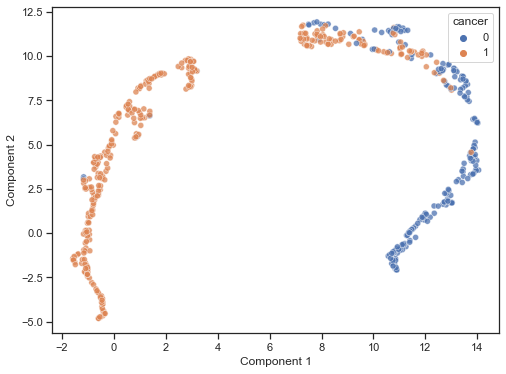

In [ ]:
df = pd.DataFrame({"Component 1": X_umap[:,0],
                   "Component 2": X_umap[:,1],
                   "cancer": y})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df, alpha=0.75)
plt.show()

### Гиперпараметры UMAP

У алгоритма UMAP тоже есть **два ключевых гиперпараметра**, которые могут очень сильно влиять на результат:

* `min_dist` - насколько близко соседние точки могут находиться в эмбеддинге
* `n_neighbors` - упрощенно: примерное количество точек в окрестности, которые учитываются алгоритмом

Попробуем посмотреть, как эти параметры влияют на визуализацию данных!

`n_neighbors` рекомендуют выбирать... тоже **в диапазоне 5 - 50**! Правда, это уже целое число.

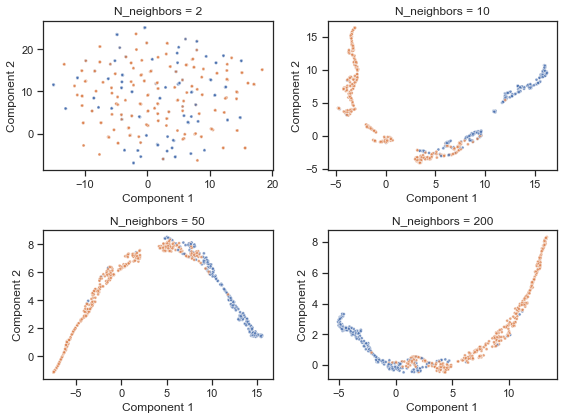

In [ ]:
plt.figure(figsize=(8, 6))
for i, n_nei in enumerate([2, 10, 50, 200], 1):
    umap = UMAP(n_components=2, random_state=42, n_neighbors=n_nei)
    X_umap = umap.fit_transform(X)
    df_s = pd.DataFrame({"Component 1": X_umap[:,0], "Component 2": X_umap[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"N_neighbors = {n_nei}")
plt.tight_layout()

`min_dist` обычно берут **в диапазоне от 0.001 до 0.5**.

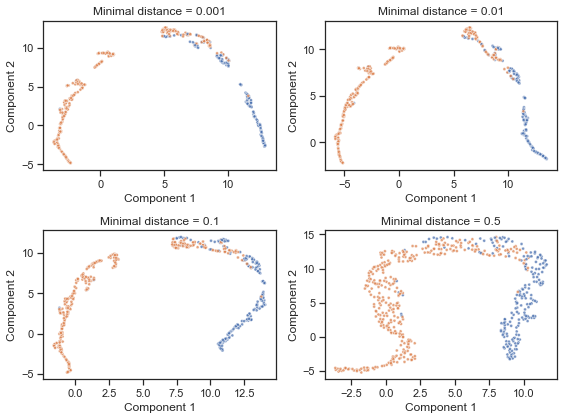

In [ ]:
plt.figure(figsize=(8, 6))
for i, dist in enumerate([0.001, 0.01, 0.1, 0.5], 1):
    umap = UMAP(n_components=2, random_state=42, min_dist=dist)
    X_umap = umap.fit_transform(X)
    df_s = pd.DataFrame({"Component 1": X_umap[:,0], "Component 2": X_umap[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"Minimal distance = {dist}")
plt.tight_layout()

**Краткие выводы**:

* Чем больше значение (`min_dist`), тем больше смещается акцент с локальной структуры на глобальную.
  * Это помогает соблюсти баланс для отображения максимально полной структуры на одном графике.
* `n_neighbors` - параметр, определяющий количество соседей у узлов в графе.
  * Так же, как и `min_dist`, помогает поддерживать баланс акцента на локальной/глобальной структуре.
  * Более высокие значения смещают общее отображение к глобальной топологии данных.
  * Недостаточно высокие значения могут породить "кластеры".

Как и в случае с t-SNE, нужно **аккуратно интерпретировать результаты UMAP**, особенно выделенные алгоритом кластеры.

Более подробно посмотреть на то, **как устроен UMAP и что происходит при изменении его параметров**, можно [здесь](https://pair-code.github.io/understanding-umap/).

### Плюсы и минусы UMAP

**Плюсы**:
* Способен выделять произвольные нелинейные зависимости
* Стохастический алгоритм -> возможно оценить стабильность "кластеров"
* **Намного быстрее t-SNE!**
* **Более гибкая настрока баланса между локальной и глобальной топологией**
* UMAP можно использовать не только для визуализации: скорость работы позволяет за разумное время получать и снижение размерности до 10-20 компонент, и уже это результат можно подавать на вход в кластеризацию и даже иногда получать что-то осмысленное. Но срабатывает далеко не всегда.
* Возможно использование в semu-supervised манере.

**Минусы**:
* **Предполагает связную структуру многообразия (manifold)**
* Медленное обучение на больших объемах данных
* Получаемое пространство почти не интерпретируемо
* Есть некоторые артефакты и искажения топологии
  * Для снижения их количества важно понимание гиперпараметров

### t-SNE и UMAP в науке

В биологии очень часто используются для визуализации транскриптомных и Single-cell данных.

![tsne_example_1.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/tsne_example_1.png)

![umap_example_1.png](https://kodomo.fbb.msu.ru/FBB/year_20/ml/mfk/lec4/umap_example_1.png)

## Batch-эффект

Зачастую в данных возникают разнообразные странные артефакты. Давайте попытаемся загрузить настоящий транскриптомный датасет и визуализировать его.

In [ ]:
escc = pd.read_csv("./data/gse53625_expression.csv", index_col=0)
escc_meta = pd.read_csv("./data/gse53625_metadata.csv", index_col=0)

In [ ]:
X = escc.values.T
y = escc_meta["Sample type"]
batch = escc_meta["Dataset"]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

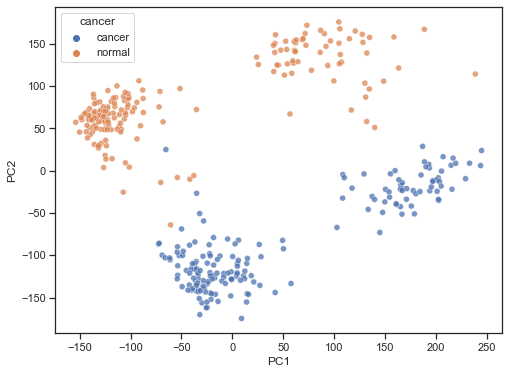

In [ ]:
df = pd.DataFrame({"PC1": X_pca[:,0], 
                   "PC2": X_pca[:,1],
                   "cancer": y})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75)

Мы наблюдаем, что по непонятным для нас причинам **данные разбиваются на 4 кластера**.

При этом наблюдаем одиникую синюю точку, зашедшую на оранжевое поле и наоборот.

Давайте попробуем отметить на графике **информацию о разных экспериментальных сериях**:

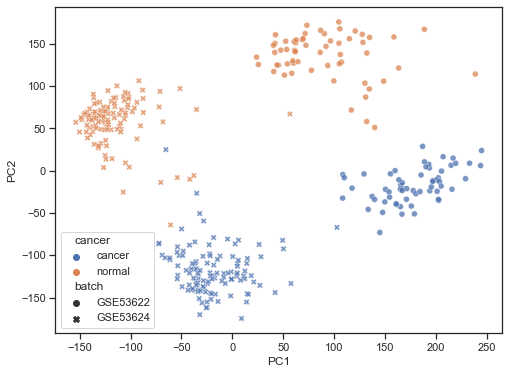

In [ ]:
df = pd.DataFrame({"PC1": X_pca[:,0],
                   "PC2": X_pca[:,1],
                   "cancer": y,
                   "batch": batch})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", style="batch", data=df, alpha=0.75)
plt.show()

Наблюдаемый нами артефакт носит название **batch-эффекта**.

В литературе есть множество определений batch-эффекта.

В общем смысле этот эффект отражает **систематические технические различия**, когда биологические образцы подготавливают, обрабатывают и измеряют **в нескольких различных группах, не имеющих связи с биологическими условиями**. Обычно такой эффект возникает **в транскриптомных данных**.

В данном случае можно понять, что это batch-эффект, потому что мы наблюдаем **2 кластера среди нормальных образцов**. Обычно предполагается, что группа образцов, принятая за "норму", сравнительно гомогенна, и кластеры, которые там возникают, вызывают подозрение.

Если в данных нет явной разбивки по каким-то параметрам типа расы/статуса курения/пола/возраста, то норма должна быть одним облачком. А опухоли могут разлетаться как угодно, ибо гипотетически может быть куча подтипов. 

Согласно описанию данных, это matched tumor-normal образцы, то есть пары образцов из одного и того же пациента, секвенировалась опухоль и соответствующая здоровая ткань.

Одинокие точки в "чужих" для себя кластерах -- это, скорее всего, просто перепутанные аннотации образцов для одного из пациентов.  

Причину возникновения batch-эффекта в данном конкретном случае определить сложно, самое простое возможное объяснение -- данные делали два разных человека, один из них мог передержать реагенты при температуре, отличающейся от протокола..

Существует много различных программ и пакетов для **исправления batch-эффектов** в транскриптомных данных.

Принцип работы этих программ заключается в измерении средней экспрессии и ее дисперсии по батчам и последующей нормализации данных.

Самый эффективный способ убрать батч - это просто взять ранги экспрессий. Так теряется много информации, но батч убирается практически железобетонно, и для некоторых применений информации всё равно будет достаточно.

Попробуем посмотреть, как будет работать **снижение размерности на скорректированных данных**:

In [ ]:
escc_corrected = pd.read_csv("./data/gse53625_expression_corrected.csv", index_col=0)

In [ ]:
X_corrected = escc_corrected.values.T
y = escc_meta["Sample type"]
batch = escc_meta["Dataset"]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_corrected)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

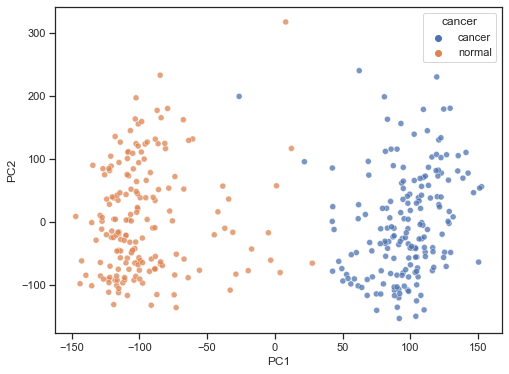

In [ ]:
df = pd.DataFrame({"PC1": X_pca[:,0],
                   "PC2": X_pca[:,1],
                   "cancer": y})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75)

Как мы видим, **обусловленные batch-эффектом кластеры уже не видны на PCA**.

**Означает ли это, что batch-эффект был убран из данных?**

## Заключение

## TL;DR 1

* В обучении без учителя есть две основные задачи: **задача кластеризации и задача снижения размерности**, но есть и другие.

* При увеличении размерности становится трунее делать выводы по данным. К счастью, **данные обычно лежат в подпространстве меньшей размерности** - многообразии (**manifold**).

* Самая простая **модель для задачи снижения размерности** - это **PCA**.

* **PCA** ищет **глобальные линейные компоненты**. Если нужен поиск нелинейных компонент, можно воспользоваться **Kernel-PCA**.

## TL;DR 2

* Два похожих метода - **t-SNE** и **UMAP** - используются для поиска нелинейного многообразия в данных.

* Для корректного использования **t-SNE** и **UMAP** нужно четкое понимание их параметризации:
  * Для t-SNE важен параметр **перплексии**: он определяет количество рассматриваемый соседей при эмбеддинге.
  * Для UMAP важны параметры **числа соседей** в графе и **минимального расстояния** в эмбеддинге. Они позволяют менять баланс отображения локальной/глобальной топологии.

* В транскриптомных данных часто возникает **batch-эффект**. Для борьбы с ним существует множество программных модулей.

# Вот и все!

## Дальше семинар